In [1]:
import pandas as pd
import numpy as pn
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.base import TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2

import warnings
warnings.filterwarnings("ignore") 

In [2]:
reddit = pd.read_csv('../data/reddit.csv')

In [3]:
reddit['subreddit'] = [1 if entry == 'PandR' else 0 for entry in reddit['subreddit']]

Sum whole reddit df and make a bar graph 

In [5]:
cvec = CountVectorizer()
X_text = reddit['title']

In [6]:
X_text = cvec.fit_transform(X_text)
X_text_df = pd.DataFrame(X_text.toarray(), columns = cvec.get_feature_names())

In [33]:
top_words = X_text_df.sum().sort_values(ascending=False)[:30]

In [34]:
top_words

the        2352
and         848
to          839
is          752
of          728
in          677
what        496
you         447
season      414
episode     412
office      405
for         396
that        389
just        370
it          338
on          315
this        278
show        274
was         273
anyone      271
have        260
michael     254
with        231
from        220
my          218
how         207
does        205
about       204
do          194
can         193
dtype: int64

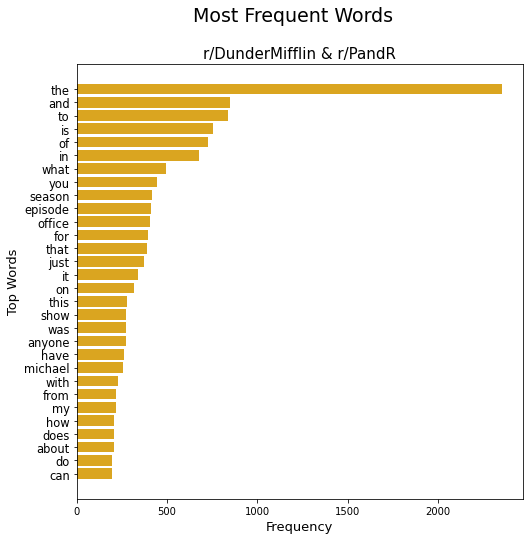

In [65]:
plt.figure(figsize=(8,8))
plt.barh(y=top_words.index[::-1],width=top_words[::-1],color='goldenrod')
plt.suptitle('Most Frequent Words',size=19)
plt.title('r/DunderMifflin & r/PandR',size=15)
plt.xlabel('Frequency',size=13)
plt.ylabel('Top Words',size=13)
plt.yticks(size=11.5);

In [36]:
poss_stopwords = list(top_words.index)

In [37]:
poss_stopwords.remove('michael')

In [38]:
poss_stopwords.remove('office')

In [39]:
poss_stopwords

['the',
 'and',
 'to',
 'is',
 'of',
 'in',
 'what',
 'you',
 'season',
 'episode',
 'for',
 'that',
 'just',
 'it',
 'on',
 'this',
 'show',
 'was',
 'anyone',
 'have',
 'with',
 'from',
 'my',
 'how',
 'does',
 'about',
 'do',
 'can']

In [40]:
off_text = reddit[reddit['subreddit']==0]['title']

In [42]:
off_text = cvec.fit_transform(off_text)
off_text_df = pd.DataFrame(off_text.toarray(), columns = cvec.get_feature_names())

In [45]:
parks_text = reddit[reddit['subreddit']==1]['title']

In [46]:
parks_text = cvec.fit_transform(parks_text)
parks_text_df = pd.DataFrame(parks_text.toarray(), columns = cvec.get_feature_names())

In [53]:
off_top = off_text_df.sum().sort_values(ascending=False)[:30]

In [54]:
parks_top = parks_text_df.sum().sort_values(ascending=False)[:30]

In [55]:
overlap = set(off_top.index).intersection(set(parks_top.index))
print(len(overlap))
overlap

21


{'and',
 'anyone',
 'episode',
 'for',
 'have',
 'in',
 'is',
 'it',
 'just',
 'of',
 'on',
 'season',
 'show',
 'that',
 'the',
 'this',
 'to',
 'was',
 'what',
 'with',
 'you'}

In [58]:
parks_only = set(parks_top.index) - set(off_top.index)
parks_only

{'can', 'does', 'how', 'leslie', 'me', 'my', 'parks', 'rec', 'ron'}

In [59]:
off_only = set(off_top.index) - set(parks_top.index)
off_only

{'about', 'do', 'dwight', 'from', 'jim', 'michael', 'office', 'pam', 'your'}

In [60]:
off_top_words = off_text_df[off_only].sum().sort_values(ascending=False)[:30]

office     369
michael    251
pam        147
from       144
jim        143
do         129
your       122
about      122
dwight     119
dtype: int64

In [61]:
parks_top_words = parks_text_df[parks_only].sum().sort_values(ascending=False)[:30]

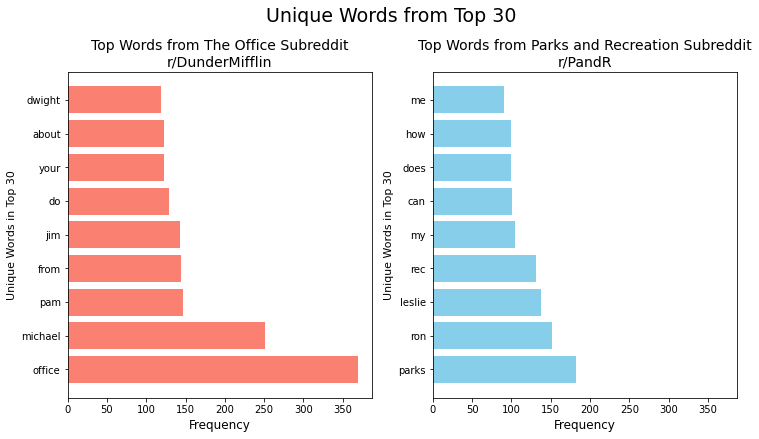

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6), sharex=True)
# add title to entire figure
fig.suptitle("Unique Words from Top 30", fontsize = 19, y = 1.03) # y is percentage of figure height for placement

ax1.barh(y=off_top_words.index,width=off_top_words,color='salmon') # ax=axes[0,1]
ax2.barh(y=parks_top_words.index,width=parks_top_words,color='skyblue')
ax1.set_title('Top Words from The Office Subreddit\nr/DunderMifflin',size=14)
ax2.set_title('Top Words from Parks and Recreation Subreddit\nr/PandR',size=14)
ax1.set_xlabel('Frequency',size=12)
ax2.set_xlabel('Frequency',size=12)
ax1.set_ylabel('Unique Words in Top 30', size=11)
ax2.set_ylabel('Unique Words in Top 30', size=11);

In [ ]:
# adapted from code from 5.03 NLP I global lesson

def title_to_words(title):
    # Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", title)
    
    # Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # Instantiate stemmer.
    p_stemmer = PorterStemmer()
    
    # Stem words.
    stemmed_words = [p_stemmer.stem(i) for i in words]
    
    # In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # Remove stopwords.
    meaningful_words = [w for w in stemmed_words if w not in stops]
    
    # Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [ ]:
total_titles = reddit.shape[0]
print(f'There are {total_titles} titles.')

In [ ]:
# adapted from code from 5.03 NLP I global lesson


# Initialize an empty list to hold the clean reviews.
clean_X_train = []
clean_X_test = []

print("Cleaning and parsing the training set titles...")

# Instantiate counter.
j = 0

# For every review in our training set...
for train_title in X_train:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_X_train.append(title_to_words(train_title))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Review {j + 1} of {total_titles}.')
    
    j += 1

# Let's do the same for our testing set.
print("Cleaning and parsing the testing set titles...")

# For every review in our testing set...
for test_title in X_test:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_X_test.append(title_to_words(test_title))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Review {j + 1} of {total_titles}.')
        
    j += 1